In [1]:
import numpy as np
import pandas as pd
import timeit
import time
import json
import re
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import string
from sklearn import linear_model
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from word_match import word_match


In [2]:
survey_path_1 = '/home/matt_valley/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/AI_survey_data/2017 to mid 2018 comments.csv'
survey_path_2 = '/home/matt_valley/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/AI_survey_data/2018 to mid 2019 comments.csv'

df = pd.read_csv(survey_path_1, header=1)
#df2 = pd.read_csv(survey_path_2, header=1)

print(len(df))
df = df.dropna(how='any')
print(len(df))

df = df.rename(columns={"Comment": "text"})
df.head()

text_clean = [len(t) for t in df.text.values]


# load spacy model

model = 'en_core_web_sm' # for testing on laptop
#model = 'en_core_web_lg'
#model = 'en_vectors_web_lg' # many more words
nlp = spacy.load(model)
#sentencizer = nlp.create_pipe("sentencizer")
#nlp.add_pipe(sentencizer)

88978
86080


In [3]:
start_time = timeit.default_timer()

match = word_match()
match_df = pd.DataFrame()
for t,text in enumerate(df['text']):
    doc = nlp(text)
    out_df = match.match_topics(t, doc)
    match_df = match_df.append(out_df)
    
match_df.reset_index(drop=True, inplace=True)

process_time = timeit.default_timer() - start_time
print(str(len(df)) + ' submissions, query took ' + str(process_time) + ' seconds')

ERROR WITH SPACY TOKEN MATCHING!  schedule.
ERROR WITH SPACY TOKEN MATCHING!  admin is always
ERROR WITH SPACY TOKEN MATCHING!  patient.
ERROR WITH SPACY TOKEN MATCHING!  staff is
ERROR WITH SPACY TOKEN MATCHING!  communication,
ERROR WITH SPACY TOKEN MATCHING!  communicate.
ERROR WITH SPACY TOKEN MATCHING!  employees.
ERROR WITH SPACY TOKEN MATCHING!  team work
ERROR WITH SPACY TOKEN MATCHING!  Team work
ERROR WITH SPACY TOKEN MATCHING!  facility.
ERROR WITH SPACY TOKEN MATCHING!  staff.
ERROR WITH SPACY TOKEN MATCHING!  co workers
ERROR WITH SPACY TOKEN MATCHING!  co-workers
ERROR WITH SPACY TOKEN MATCHING!  staff.
ERROR WITH SPACY TOKEN MATCHING!  staff.  
ERROR WITH SPACY TOKEN MATCHING!  Team work
ERROR WITH SPACY TOKEN MATCHING!  Co workers
ERROR WITH SPACY TOKEN MATCHING!  resident.
ERROR WITH SPACY TOKEN MATCHING!  schedule.
ERROR WITH SPACY TOKEN MATCHING!  employees.
ERROR WITH SPACY TOKEN MATCHING!  staff.
ERROR WITH SPACY TOKEN MATCHING!  staff.  
ERROR WITH SPACY TOKEN MAT

In [7]:
print(len(df))
print(len(match_df))
pd.to_pickle(match_df, '~/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/match_df.pkl')

86080
62920


In [3]:
match_df = pd.read_pickle('~/PycharmProjects/insight_2020a_project/Activated_Insights_consulting/match_df.pkl')

In [5]:
### LOAD EMBEDDING MODEL

model = 'en_vectors_web_lg'
nlp_vec = spacy.load(model)

y_vec = []
topics = match_df['topic'].unique()
for topic in topics:
    y_doc = nlp(topic)
    y_vec.append(y_doc.vector)

In [6]:
y_vec = np.array(y_vec)
y_vec.shape

(16, 96)

In [11]:
# BUILD CONTEXT VECTORS

X = []
for n,text in enumerate(match_df['context_span'].values):
    X.append(nlp(text).vector)
X = np.array(X)
print(X.shape)

(62920, 96)


In [17]:
# dimensionality reduce

pca = PCA(n_components=20, whiten=True, random_state=42)
pca.fit(X, y)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
    svd_solver='auto', tol=0.0, whiten=True)

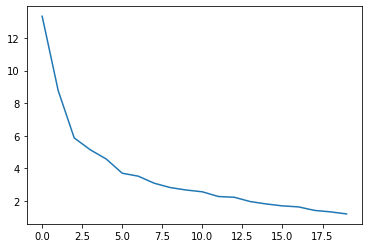

In [18]:
plt.plot(pca.explained_variance_)

In [34]:
'''
do tfidf
'''

all_tfidf = []
topics = match_df['topic'].unique()
for topic in topics:
    temp_df = match_df[match_df['topic']==topic]
    data = [sent for sent in temp_df.comment_text]
    
    n_features = 1000
    n_components = 12
    n_top_words = 8
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')

    t0 = time.time()
    tfidf = tfidf_vectorizer.fit_transform(data)

    feature_array = np.array(tfidf_vectorizer.get_feature_names())
    tfidf_sorting = np.argsort(tfidf.toarray()).flatten()[::-1]
    
    n = 10
    top_n = feature_array[tfidf_sorting][:n]
    print(topic)
    print(top_n)
        
    all_tfidf.append(tfidf)
    print("done in %0.3fs." % (time.time() - t0))


Recognition
['cost' 'greatly' 'living' 'raise' 'believe' 'appreciate' 'staff'
 'finding' 'financial' 'field']
done in 0.105s.
Schedule
['rates' 'filling' 'called' 'higher' 'better' 'difference' 'loved'
 'morale' 'consider' 'huge']
done in 0.113s.
Benefits and leave
['salary' 'benefits' 'yes' 'feels' 'fmla' 'flu' 'floor' 'flexible'
 'flexibility' 'flex']
done in 0.191s.
Customers
['rehab' 'don' 'department' 'administrator' 'year' 'reason' 'example'
 'management' 'long' 'patients']
done in 0.955s.
Staffing level
['salary' 'fair' 'new' 'previous' 'old' 'gets' 'hired' 'hire' 'employees'
 'people']
done in 0.663s.
Quality of care
['living' 'memory' 'question' 'supportive' 'levels' 'services' 'assisted'
 'skilled' 'campus' 'work']
done in 0.149s.
Co-workers/teamwork
['managers' 'does' 'line' 'facility' 'staff' 'members' 'respect' 'level'
 'voice' 'consideration']
done in 0.857s.
Pay
['higher' 'pay' 'yes' 'far' 'filled' 'figure' 'field' 'felt' 'feels'
 'feeling']
done in 0.279s.
Support and r

In [23]:
print(TfidfVectorizer.get_feature_names(tfidf))
tfidf.

AttributeError: _check_vocabulary not found

In [23]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [17]:
lda = LatentDirichletAllocation(n_components=n_components,random_state=0, verbose=1, max_iter=20)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names()

print(tf_feature_names)

print_top_words(lda, tf_feature_names, n_top_words)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20
['10', '100', '30', '40', '401', '401k', 'ability', 'able', 'absent', 'absolutely', 'abuse', 'accept', 'access', 'accommodate', 'accomplish', 'according', 'accountability', 'accountable', 'acknowledgement', 'act', 'active', 'actively', 'activities', 'activity', 'actual', 'actually', 'acuity', 'add', 'added', 'additional', 'address', 'addressed', 'adequate', 'administration', 'administrative', 'administrato